In [29]:
import h5py
import dxchange
import numpy as np
import torch as tc
import torch.nn.functional as tcf
import tomopy
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
from sklearn.decomposition import PCA, TruncatedSVD, FastICA
from sklearn.cross_decomposition import *

In [30]:
# Load projections around a certain angle
_, _, _, theta = dxchange.read_aps_32id('raw/tomo_00001.h5', proj=(0, 1))
n_proj_rad = 12
n_skip = 50
i_theta_cen = len(theta) // 2
prj_ind_range = (i_theta_cen - n_skip * n_proj_rad, i_theta_cen + n_skip * n_proj_rad + 1, n_skip)
prj, flt, drk, theta = dxchange.read_aps_32id('raw/tomo_00001.h5', proj=prj_ind_range)
prj = tomopy.normalize(prj, flt, drk)
prj = tomopy.minus_log(prj)
theta_center = theta[i_theta_cen]
this_theta_ls = theta[slice(*prj_ind_range)]
this_theta_ls = this_theta_ls - theta_center
print(this_theta_ls)

# downsample
prj = zoom(prj, [1, 0.25, 0.25])
print(prj.shape)

[-1.25663706 -1.15191731 -1.04719755 -0.94230326 -0.83775804 -0.73303829
 -0.62831853 -0.52359878 -0.41887902 -0.31415927 -0.20943951 -0.10471976
  0.          0.10471976  0.20943951  0.31415927  0.41887902  0.52359878
  0.62831853  0.73303829  0.83775804  0.9424778   1.04719755  1.15191731
  1.25663706]
(25, 448, 512)


In [31]:
def to_numpy(var):
    if var.device.type == 'cpu':
        return var.data.numpy()
    else:
        return var.cpu().data.numpy()

def rescale(x, scale_factor):
    a = tc.tensor([[[1. / scale_factor[1], 0, 0],
                    [0, 1./ scale_factor[0], 0]]])
    a = tcf.affine_grid(a, [1, 1, *prj.shape[1:]])
    try:
        x = tcf.grid_sample(x.reshape([1, 1, *x.shape]), a.double(), align_corners=True, padding_mode='border')
    except:
        x = tcf.grid_sample(x.reshape([1, 1, *x.shape]), a, align_corners=True, padding_mode='border')
    return x[0, 0]

def total_variation(arr, axis_offset=0):
    """
    Calculate total variation of a 3D array.
    :param arr: 3D Tensor.
    :return: Scalar.
    """
    arr_size = 1
    for i in range(len(arr.shape)):
        arr_size = arr_size * arr.shape[i]
    res = tc.sum(tc.abs(tc.roll(arr, 1, dims=0 + axis_offset) - arr))
    res = res + tc.sum(tc.abs(tc.roll(arr, 1, dims=1 + axis_offset) - arr))
    res = res / arr_size
    return res

## Stretch projection images

In [32]:
device = None
prj_trans = np.zeros_like(prj)
for i in range(len(this_theta_ls)):
    x = prj[i]
    x = tc.tensor(x, requires_grad=False, device=device)
    x = rescale(x, scale_factor=[1, 1 / np.cos(this_theta_ls[i])])
    x = to_numpy(x)
    prj_trans[i] = x

/home/beams/B282788/anaconda3/envs/py3/lib/python3.6/site-packages/torch/nn/functional.py:2764: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


## Sum up images

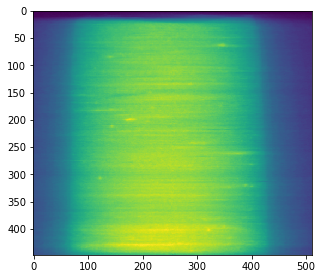

In [33]:
prj_sum = np.sum(prj_trans, axis=0)
plt.figure(figsize=(5, 5))
plt.imshow(prj_sum)

In [34]:
dxchange.write_tiff(prj_sum, 'transform_correlate/prj_sum', overwrite=True, dtype='float32')
dxchange.write_tiff(prj[len(prj) // 2], 'transform_correlate/prj_center', overwrite=True, dtype='float32')

## Use ICA to find eigen-projections

In [37]:
#eigens = PCA(100, svd_solver='randomized')
#eigens = TruncatedSVD(100, algorithm='randomized')
eigens = FastICA(25)
eigens.fit(prj_trans.reshape([prj_trans.shape[0], -1]))

FastICA(n_components=25)

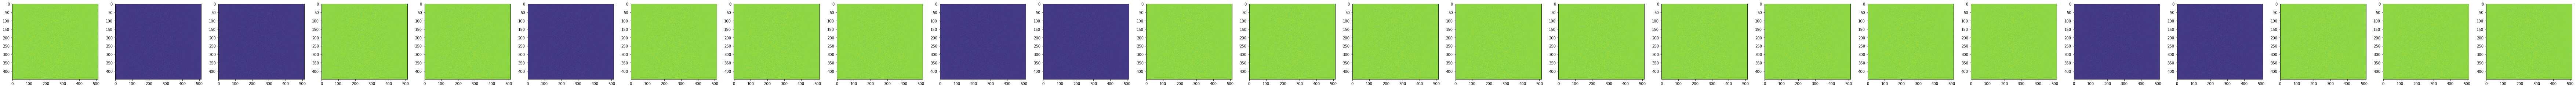

In [38]:
#print(eigens.explained_variance_ratio_)
fig, axes = plt.subplots(1, len(eigens.components_), figsize=(125, 5))
for ii, i in enumerate(range(len(eigens.components_))):
    eigen_img = eigens.components_[i].reshape(prj_trans.shape[1:])
    axes[ii].imshow(eigen_img)
plt.show()
#dxchange.write_tiff(eigens.components_[0].reshape(prj_trans.shape[1:]), 'transform_correlate/pca_0', overwrite=True, dtype='float32')
dxchange.write_tiff(eigens.components_.reshape([len(eigens.components_), *prj_trans.shape[1:]]), 
                    'transform_correlate/ica_all', overwrite=True, dtype='float32')
dxchange.write_tiff(prj_trans, 'transform_correlate/prj_trans', dtype='float32', overwrite=True)

We can find n principal directions that maximize the variance. However, to get the common signal among all projections, we actually want the direction that **minimizes** the variance. We assume that this direction is orthogonal to the largest principal directions. 

In [149]:
def get_inner_prod_loss(x, y0):
    l = tc.abs(tc.sum(x * y0)) + 1.e1 * total_variation(x)
    return l

prj_prc = eigens.components_[:10]
prj_prc = prj_prc.reshape([prj_prc.shape[0], *prj_trans.shape[1:]])
y0 = tc.tensor(prj_prc, requires_grad=False)
x = tc.tensor(eigens.components_[-1].reshape(prj_trans.shape[1:]), requires_grad=True)
opt = tc.optim.Adam([x], 1e-5)
for i_epoch in range(1000):
    opt.zero_grad()
    loss = get_inner_prod_loss(x, y0)
    loss.backward()
    opt.step()
    if (i_epoch + 1) % 10 == 0:
        print('{}: {}'.format(i_epoch, to_numpy(loss)))


9: 0.03701773285865784
19: 0.0401633121073246
29: 0.03715307638049126
39: 0.03922443836927414
49: 0.037301819771528244
59: 0.0377453938126564
69: 0.03651072457432747
79: 0.03726630285382271
89: 0.03571976721286774
99: 0.036319661885499954
109: 0.03504909574985504
119: 0.036160096526145935
129: 0.037148408591747284
139: 0.03524237871170044
149: 0.03717798367142677
159: 0.03486616536974907
169: 0.03460274264216423
179: 0.034265924245119095
189: 0.034591928124427795
199: 0.03409872576594353
209: 0.0369536317884922
219: 0.03442711383104324
229: 0.036510128527879715
239: 0.034667570143938065
249: 0.03515785187482834
259: 0.03396771848201752
269: 0.034765176475048065
279: 0.03325561434030533
289: 0.03391873836517334
299: 0.03265831992030144
309: 0.03313055261969566
319: 0.03269990161061287
329: 0.03557903319597244
339: 0.03308293595910072
349: 0.03222145885229111
359: 0.033269379287958145
369: 0.034322213381528854
379: 0.032427411526441574
389: 0.032417550683021545
399: 0.034705691039562225


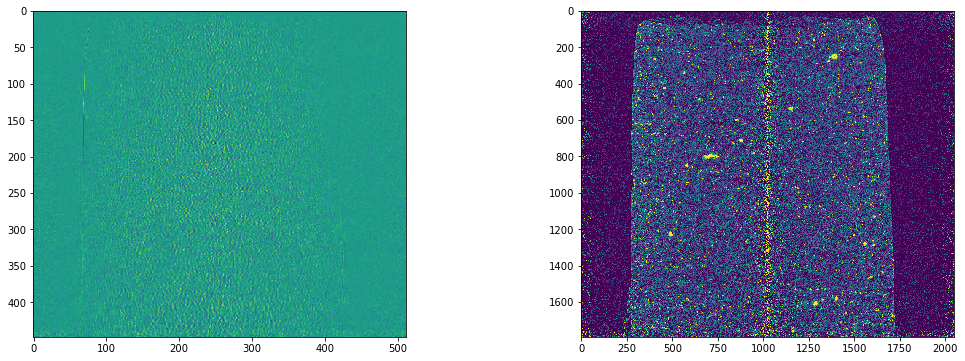

In [164]:
rec_true = dxchange.read_tiff('tomo_rec/rec_reslice.tiff')
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
axes[0].imshow(to_numpy(x))
axes[1].imshow(rec_true, vmin=0, vmax=0.002)
dxchange.write_tiff(to_numpy(x), 'transform_correlate/pca_ortho', dtype='float32', overwrite=True)

## Find the image that has maximum total correlation with all stretched projections

In [42]:
def get_correlation_loss(x, x_prj):
    x = x - tc.mean(x)
    l = -tc.sum(x * x_prj) #+ 1.e1 * total_variation(x)
    return l

x_prj = prj_trans - np.mean(prj_trans, axis=0)
x_prj = tc.tensor(x_prj, requires_grad=False)
x_init = eigens.components_[8].reshape(prj_trans.shape[1:])
x = tc.tensor(x_init, requires_grad=True)
opt = tc.optim.Adam([x], 1e-3)

for i_epoch in range(100):
    opt.zero_grad()
    loss = get_correlation_loss(x, x_prj)
    loss.backward()
    opt.step()
    if i_epoch % 1 == 0:
        print('{}: {}'.format(i_epoch, to_numpy(loss)))


0: -0.9820791394216144
1: -0.98221622862917
2: -0.9823533178540629
3: -0.9824904070732146
4: -0.9826274962872503
5: -0.9827645855094147
6: -0.9829016747190735
7: -0.9830387639410105
8: -0.9831758531652781
9: -0.9833129423802802
10: -0.9834500316042067
11: -0.9835871208208573
12: -0.9837242100359731
13: -0.9838612992519415
14: -0.9839983884633625
15: -0.9841354776988851
16: -0.9842725669164452
17: -0.9844096561280367
18: -0.9845467453457672
19: -0.9846838345636115
20: -0.9848209237950982
21: -0.9849580130017443
22: -0.9850951022191907
23: -0.9852321914303275
24: -0.9853692806605068
25: -0.9855063698781805
26: -0.9856434591053471
27: -0.985780548312448
28: -0.9859176375290417
29: -0.9860547267512629
30: -0.9861918159724041
31: -0.9863289051906463
32: -0.986465994407979
33: -0.9866030836327013
34: -0.9867401728404843
35: -0.9868772620691857
36: -0.9870143512751497
37: -0.9871514405026574
38: -0.9872885297193648
39: -0.9874256189316384
40: -0.9875627081582934
41: -0.9876997973751145
42: -0

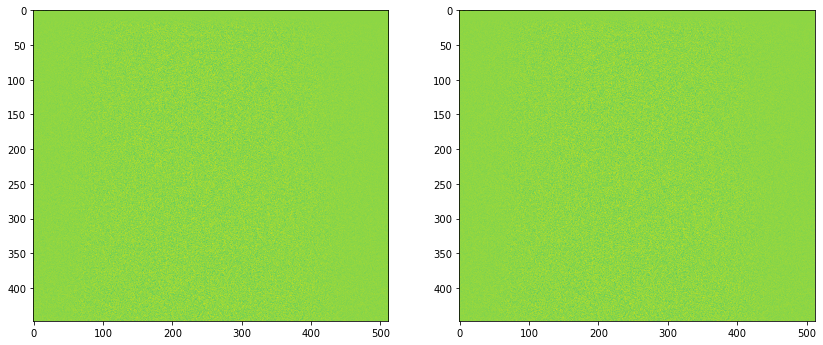

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].imshow(x_init)
axes[1].imshow(to_numpy(x))
#axes[2].imshow(prj_sum)

## ... or use CCA

In [ ]:
i = 0
cca_x = prj_trans[i:i+2].reshape([2, -1])
cca_y = prj_trans[i + prj_trans.shape[0] // 2:i + prj_trans.shape[0] // 2 + 2].reshape([2, -1])
#cca = CCA(n_components=1, max_iter=50)
cca = PLSSVD(n_components=1)
cca.fit(cca_x, cca_y)

In [ ]:
plt.imshow(cca.x_weights[0].reshape[prj_trans.shape[1:]])
plt.show()

## Standard deviation rating

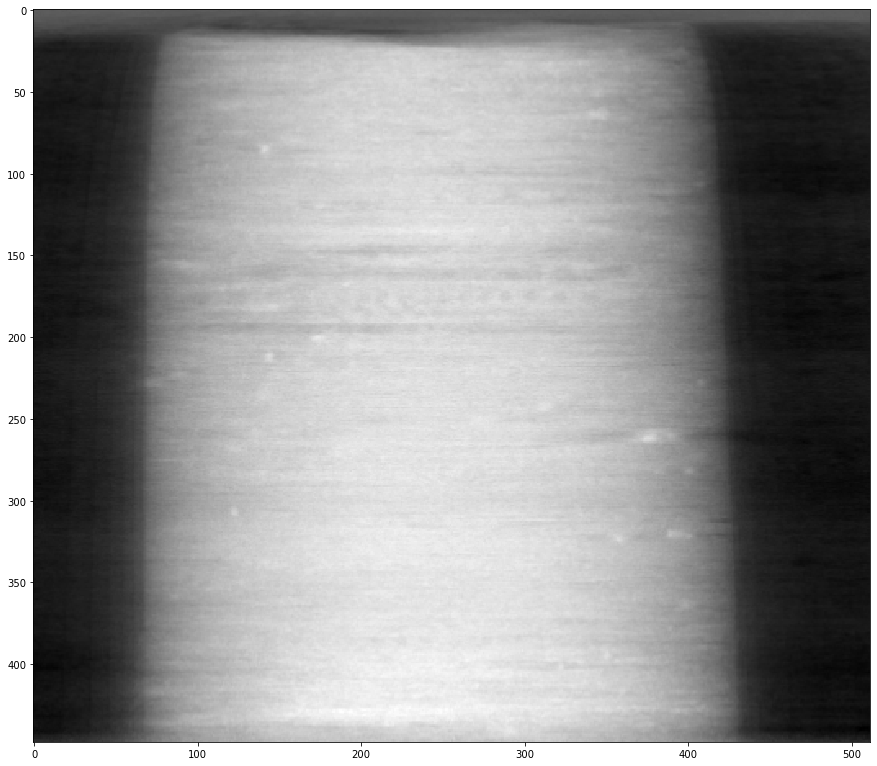

In [53]:
img_std = np.std(prj_trans, axis=0)
img = prj_sum - img_std * 10/ 0.1736
plt.figure(figsize=(15, 15))
plt.imshow(img, cmap='gray')
plt.show()
dxchange.write_tiff(img_std, 'transform_correlate/img_std', dtype='float32', overwrite=True)

## Deconvolution of blurring kernel

In [71]:
def to_numpy(var):
    if var.device.type == 'cpu':
        return var.data.numpy()
    else:
        return var.cpu().data.numpy()

In [114]:
def get_loss(x, kernel, y0):
    x = x.reshape([1, 1, *x.shape])
    kernel = kernel.reshape([1, 1, *kernel.shape])
    y = tcf.conv2d(x, kernel, padding=(0, kernel.shape[-1] // 2))
    y = y[0, 0]
    l = tc.mean((y - y0) ** 2)
    return l, y

mask = dxchange.read_tiff('transform_fitting/mask.tiff')
mask = tc.tensor(mask, requires_grad=False)
kernel = tc.full([1, 21], 1., requires_grad=True)
y0 = tc.tensor(prj_sum, requires_grad=False)
x = tc.tensor(np.zeros_like(prj_sum), requires_grad=True)
opt = tc.optim.Adam([x, kernel], 1e-3)

for i_epoch in range(1000):
    opt.zero_grad()
    loss, y = get_loss(x, kernel, y0)
    loss.backward()
    opt.step()
    x.data = x.data * mask
    if (i_epoch + 1) % 10 == 0:
        print('{}: {}'.format(i_epoch, to_numpy(loss)))

9: 1578.2127685546875
19: 1564.462890625
29: 1550.4188232421875
39: 1536.0361328125
49: 1521.287109375
59: 1506.1566162109375
69: 1490.6387939453125
79: 1474.7337646484375
89: 1458.445556640625
99: 1441.7806396484375
109: 1424.7474365234375
119: 1407.3563232421875
129: 1389.6181640625
139: 1371.5447998046875
149: 1353.1495361328125
159: 1334.4459228515625
169: 1315.4476318359375
179: 1296.1700439453125
189: 1276.628173828125
199: 1256.837646484375
209: 1236.8145751953125
219: 1216.5755615234375
229: 1196.1375732421875
239: 1175.5169677734375
249: 1154.731689453125
259: 1133.798828125
269: 1112.7362060546875
279: 1091.561767578125
289: 1070.293212890625
299: 1048.9483642578125
309: 1027.545654296875
319: 1006.1024780273438
329: 984.6371459960938
339: 963.1675415039062
349: 941.7112426757812
359: 920.2860107421875
369: 898.9094848632812
379: 877.5984497070312
389: 856.3704223632812
399: 835.2420043945312
409: 814.2296142578125
419: 793.3497924804688
429: 772.6178588867188
439: 752.049682

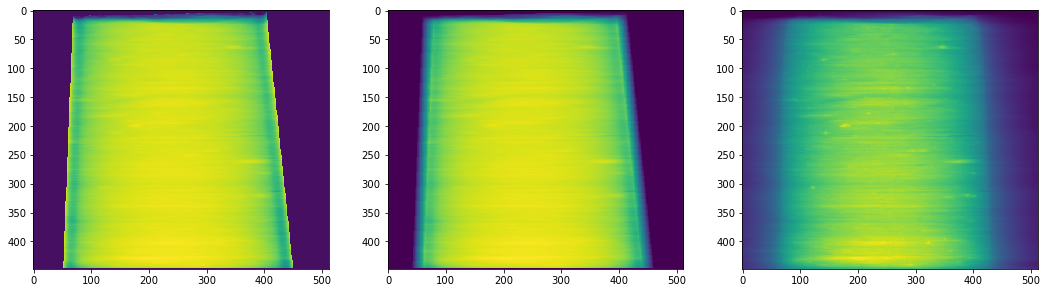

In [115]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes[0].imshow(to_numpy(x))
axes[1].imshow(to_numpy(y))
axes[2].imshow(prj_sum)
dxchange.write_tiff(to_numpy(x), 'transform_correlate/deconv.tiff', dtype='float32', overwrite=True)

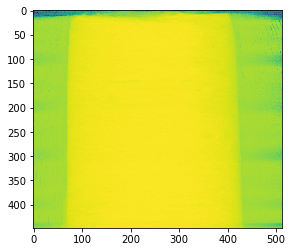

In [119]:
prj_min = np.min(prj_trans, axis=0) / prj_sum
plt.imshow(prj_min)
plt.show()
dxchange.write_tiff(prj_min, 'transform_correlate/prj_min.tiff', dtype='float32', overwrite=True)